In [54]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/d9206305195583c08400cb2237c837cc42df2e65/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [55]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter


In [25]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")


('ratings_test.txt', <http.client.HTTPMessage at 0x7d26f7ced9c0>)

In [26]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')


In [27]:
print("{} {}".format(len(train_data), len(test_data)))

150000 50000


In [28]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [29]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [30]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [32]:
train_data.drop_duplicates(subset=['document'], inplace=True)

<Axes: >

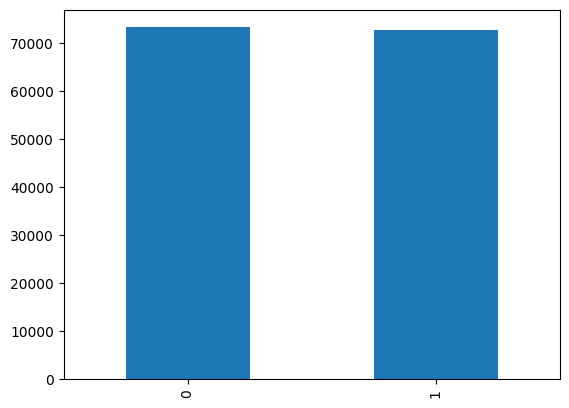

In [33]:
train_data['label'].value_counts().plot(kind = 'bar')


In [34]:
if train_data.isnull().values.any():
  print(train_data.isnull().sum())


id          0
document    1
label       0
dtype: int64


In [35]:
train_data = train_data.dropna(how='any')

#데이터 전처리

In [36]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]


<ipython-input-36-4419b0600db1>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-36-4419b0600db1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [37]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())


<ipython-input-37-c2f9538d5bc3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


id            0
document    789
label         0
dtype: int64


<ipython-input-37-c2f9538d5bc3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
<ipython-input-37-c2f9538d5bc3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'].replace('', np.nan, inplace=True)


In [38]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))


145393


In [39]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


<ipython-input-39-c182d8fa0991>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-39-c182d8fa0991>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


전처리 후 테스트용 샘플의 개수 : 48852


#토큰화

불용어 제거

In [40]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']


In [58]:
from konlpy.tag import Okt


In [59]:
okt = Okt()

In [60]:
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만드는', '게', '나을', '뻔']

In [61]:
X_train = []
for sentence in tqdm(train_data['document']):
  tokenized_sentence = okt.morphs(sentence)
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [12:15<00:00, 197.79it/s]


In [62]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)


100%|██████████| 48852/48852 [04:25<00:00, 184.27it/s]


#학습 데이터, 검증 데이터, 테스트 데이터

In [63]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [64]:
print('--------학습 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')


--------학습 데이터의 비율-----------
부정 리뷰 = 50.238%
긍정 리뷰 = 49.762%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.239%
긍정 리뷰 = 49.761%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


#Vocab 만들기

In [65]:
vocab = []
for s in X_train:
  for word in s:
    vocab.append(word)
word_counts = Counter(vocab)
print("총 단어 수: ", len(word_counts))

총 단어 수:  88276


단어 빈도수가 높은 순서로 가져오기: 단어 빈도수가 낮은 단어들을 거를 수 있다.

In [66]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
vocab[:10]

['영화', '너무', '정말', '만', '적', '진짜', '으로', '로', '점', '에서']

In [67]:
threshold = 3
total_cnt = len(word_counts)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in word_counts.items():
  total_freq = total_freq + value

  if value < threshold:
    rare_cnt +=1
    rare_freq +=value
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 88276
등장 빈도가 2번 이하인 희귀 단어의 수: 60078
단어 집합에서 희귀 단어의 비율: 68.05700303593277
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.644509532507002


빈도수가 2 이하인 단어 제거

In [68]:
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))


단어 집합의 크기 : 28198


In [69]:
word2index = {}
word2index['<PAD>'] = 0
word2index['<UNK>']= 1
for index, word in enumerate(vocab):
  word2index[word] = index+2
vocab_size = len(word2index)
print(vocab_size)

28200


In [71]:
print('단어 <PAD>와 맵핑되는 정수 :', word2index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word2index['<UNK>'])
print('단어 영화와 맵핑되는 정수 :', word2index['영화'])


단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 영화와 맵핑되는 정수 : 2


Encoding된 Vocab에 대해 입력 데이터를 인코딩하는 함수

In [72]:
def texts_to_sequences(tokenized_X_data, word2index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
        index_sequences.append(word2index[word])
      except KeyError:
        index_sequences.append(word2index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

Train, Valid, Test 데이터 다 인코딩하기

In [73]:
encoded_X_train = texts_to_sequences(X_train, word2index)
encoded_X_valid = texts_to_sequences(X_valid, word2index)
encoded_X_test = texts_to_sequences(X_test, word2index)


In [74]:
for sent in encoded_X_train[:5]:
  print(sent)

[373, 2422, 7023, 16429]
[9560, 3697, 75, 2346, 544, 24, 1, 615]
[428, 582, 243, 19004, 256, 2893, 1733, 1557, 1, 2569, 60, 922, 279, 159, 375, 1, 3621, 1419, 24, 4345, 4235, 179, 2423, 68, 126, 3241, 5757, 19004, 1948, 989, 875, 2705, 1200]
[3, 205]
[13, 3, 2600, 100, 2, 4693, 14520, 3545]


인코딩된 정보를 다시 디코딩하기

In [75]:
index2word = {}
for key, value in word2index.items():
  index2word[value] = key
decoded_sample = [index2word[word] for word in encoded_X_train[0]]
print('기존 text: ', X_train[0])
print('복원 text: ', decoded_sample)

기존 text:  ['이야', '어쩜', '이렇게나', '지루할수가']
복원 text:  ['이야', '어쩜', '이렇게나', '지루할수가']


패딩하기

최대 길이:  69
평균 길이:  10.925228261430266


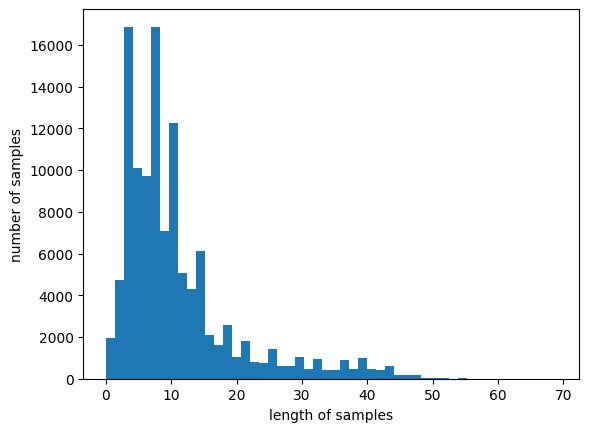

In [76]:
print("최대 길이: ", max(len(review) for review in encoded_X_train))
print("평균 길이: ", sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins = 50)

plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [83]:
max_len=30

In [80]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
      count+=1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [84]:
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.11850680055711


In [85]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) !=0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (116314, 30)
검증 데이터의 크기 : (29079, 30)
테스트 데이터의 크기 : (48852, 30)


#LSTM 사용하여 분류 모델 만들기


In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [87]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)


cpu와 cuda 중 다음 기기로 학습함: cpu


In [88]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])


tensor([0, 1, 1, 1, 1])


- 단어 벡터의 차원 = 100
- 문장 길이 = 500
- 배치 크기 = 32
- 데이터 개수 = 2만
- LSTM의 은닉층의 크기 = 128
- 분류하고자 하는 카테고리 개수 = 2개

(32, 500) => 입력 데이터의 형태 => 임베딩 층 통과 후 => (32, 500, 100) => LSTM 통과 후 => (32, 128) => Softmax 출력층 통과 후 => (32, 2)

In [89]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(TextClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
  def forward(self, x):
    embedded = self.embedding(x)
    lstm_out, (hidden,cell) = self.lstm(embedded)
    last_hidden = hidden.squeeze(0)
    logits = self.fc(last_hidden)
    return logits

In [90]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)


In [91]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [92]:
def calculate_accuracy(logits, labels):
  predicted = torch.argmax(logits, dim=1)
  correct = (predicted==labels).sum().item()
  total = labels.size(0)
  accuracy = correct / total
  return accuracy

In [93]:
def evaluate(model, valid_dataloader, critierion, device):
  val_loss=0
  val_correct=0
  val_total = 0

  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in valid_dataloader:
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)
      logits = model(batch_X)
      loss=criterion(logits, batch_y)
      val_loss +=loss.item()
      val_correct +=calculate_accuracy(logits, batch_y) * batch_y.size(0)
      val_total += batch_y.size(0)

  val_accuracy = val_correct / val_total
  val_loss /= len(valid_dataloader)
  return val_loss, val_accuracy

In [94]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


Epoch 1/5:
Train Loss: 0.5120, Train Accuracy: 0.7140
Validation Loss: 0.3836, Validation Accuracy: 0.8243
Validation loss improved from inf to 0.3836. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.3315, Train Accuracy: 0.8549
Validation Loss: 0.3523, Validation Accuracy: 0.8408
Validation loss improved from 0.3836 to 0.3523. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 0.2609, Train Accuracy: 0.8904
Validation Loss: 0.3590, Validation Accuracy: 0.8447
Epoch 4/5:
Train Loss: 0.1988, Train Accuracy: 0.9195
Validation Loss: 0.3911, Validation Accuracy: 0.8392
Epoch 5/5:
Train Loss: 0.1447, Train Accuracy: 0.9436
Validation Loss: 0.4665, Validation Accuracy: 0.8378


In [95]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)


TextClassifier(
  (embedding): Embedding(28200, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [99]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    tokens = okt.morphs(text) # 토큰화
    tokens = [word for word in tokens if not word in stopwords] # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    # Convert tokens to tensor
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag


In [100]:
test_input = "윤석열 뭐하냐"
predict(test_input, model, word2index, index_to_tag)

'부정'

In [102]:
test_input = "운지"
predict(test_input, model, word2index, index_to_tag)

'긍정'